In [ ]:
!pip install --upgrade tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.7/489.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.12.0
    Uninstalling tensorflow-2.12.0:
 

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2 
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import LSTM, Bidirectional, Conv1D, concatenate, Permute, Dropout, Dense, Input
from tensorflow.keras.metrics import Precision
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score, f1_score
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Dataset

In [ ]:
folder_path = "/content/drive/MyDrive/DL_project/"
classes = [0,1,2,3,4]
classes_names = ["None", "Mild", "Moderate", "Severe", "Proliferative"]
train_images = []
y_train = []
test_images = []
y_test = []

In [ ]:
img_size = 224

In [ ]:
def get_image(path: str)-> np.ndarray:
    img = cv2.resize(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY), (img_size, img_size))
    return img

In [ ]:
train_l = 25
test_l = 5

In [ ]:
for cli in classes:
    train_cl = os.listdir(folder_path+f"TRAIN/TRAIN_{cli}/")
    for fl in train_cl:
        train_images.append(get_image(folder_path+f"TRAIN/TRAIN_{cli}/"+fl))
        y_train.append(cli)

    test_cl = os.listdir(folder_path+f"TEST/TEST_{cli}/")
    for fl in test_cl:
        test_images.append(get_image(folder_path+f"TEST/TEST_{cli}/"+fl))
        y_test.append(cli)

train_images = np.array(train_images, dtype=np.float32)
train_images /= 255.0
y_train = np.array(y_train)
test_images= np.array(test_images, dtype=np.float32)
test_images /= 255.0
y_test = np.array(y_test)

perm = np.random.permutation(len(y_train))
train_images = train_images[perm]
y_train = y_train[perm]

### Defining the Model (Stacked LSTM)

In [ ]:
batch_size = 16
num_classes = len(classes)
epochs = 15

row_hidden = 128
col_hidden = 128

row, col = train_images.shape[1:]

input = Input(shape=(row, col))

def lstm_pipe(in_layer):
    x = Conv1D(row_hidden, kernel_size=3, padding = 'same')(in_layer)
    x = Conv1D(row_hidden, kernel_size=3, padding = 'same')(x)
    encoded_rows = Bidirectional(LSTM(row_hidden, return_sequences = True))(x)
    return LSTM(col_hidden)(encoded_rows)
# read it by rows
first_read = lstm_pipe(input)
# read it by columns
trans_read = lstm_pipe(Permute(dims = (1,2))(input))
encoded_columns = concatenate([first_read, trans_read])
encoded_columns = Dropout(0.2)(encoded_columns)
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(input, prediction)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224)]   0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 224, 224)     0           ['input_3[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 224, 128)     86144       ['input_3[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 224, 128)     86144       ['permute_2[0][0]']              
                                                                                            

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, y_train, validation_split=0.25, epochs=epochs)

Epoch 1/15
20/20 [==============================] - 15s 183ms/step - loss: 1.3387 - accuracy: 0.3968 - val_loss: 1.1556 - val_accuracy: 0.4783
Epoch 2/15
20/20 [==============================] - 1s 65ms/step - loss: 1.2322 - accuracy: 0.4613 - val_loss: 1.1228 - val_accuracy: 0.5314
Epoch 3/15
20/20 [==============================] - 1s 65ms/step - loss: 1.1576 - accuracy: 0.4758 - val_loss: 1.1171 - val_accuracy: 0.5266
Epoch 4/15
20/20 [==============================] - 1s 65ms/step - loss: 1.1239 - accuracy: 0.4887 - val_loss: 1.1437 - val_accuracy: 0.5121
Epoch 5/15
20/20 [==============================] - 2s 94ms/step - loss: 1.1069 - accuracy: 0.5000 - val_loss: 1.1029 - val_accuracy: 0.5024
Epoch 6/15
20/20 [==============================] - 2s 78ms/step - loss: 1.0940 - accuracy: 0.5113 - val_loss: 1.1091 - val_accuracy: 0.4976
Epoch 7/15
20/20 [==============================] - 1s 72ms/step - loss: 1.0878 - accuracy: 0.4935 - val_loss: 1.0908 - val_accuracy: 0.5169
Epoch 8/15


In [ ]:
model.save(folder_path+"Models/stacked_lstm_model.h5")

### Plots

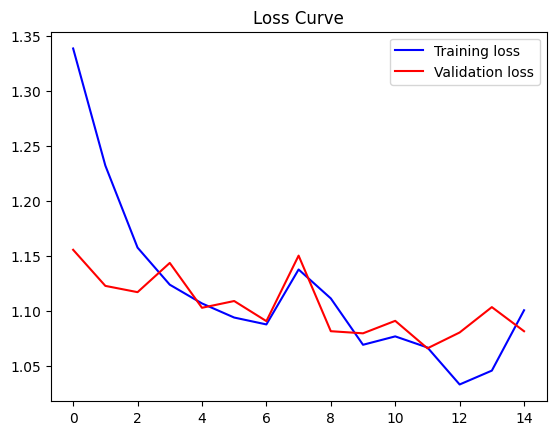

In [ ]:
#plot loss
plt.title('Loss Curve')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')
plt.legend(['Training loss', 'Validation loss'])
plt.show()

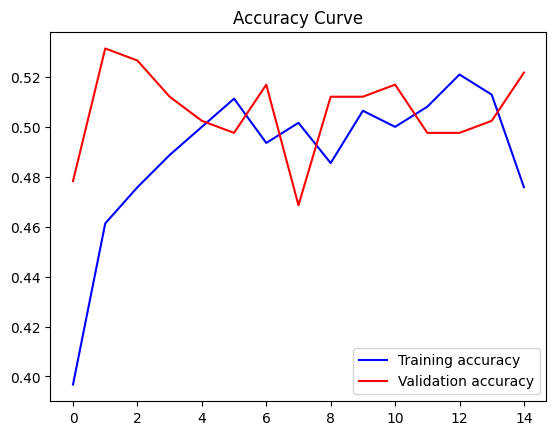

In [ ]:
#plot accuracy
plt.title('Accuracy Curve')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

### Testing on test set

In [ ]:
test_loss, test_acc = model.evaluate(test_images, y_test, batch_size=batch_size)

42/42 [==============================] - 1s 31ms/step - loss: 1.2300 - accuracy: 0.4894


In [ ]:
test_preds = model.predict(test_images)
test_preds = np.argmax(test_preds, axis=1)

In [ ]:
test_kappa = cohen_kappa_score(y_test, test_preds)
test_precision = precision_score(y_test, test_preds, average='macro')
test_f1 = f1_score(y_test, test_preds, average='macro')

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


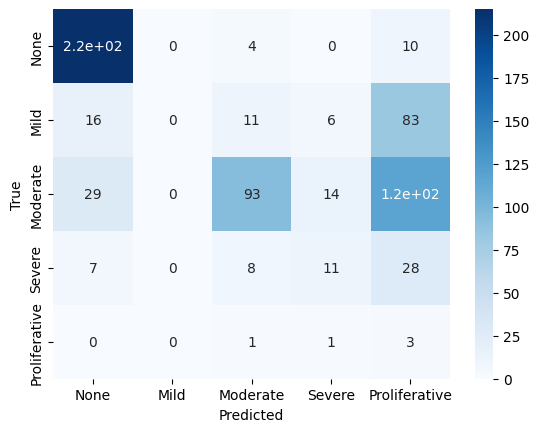

In [ ]:
conf_mat = confusion_matrix(y_test, test_preds)

sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Results on test set")
print(f"Loss: {test_loss}")
print(f"Accuracy: {test_acc}")
print(f"Kappa Score: {test_kappa}")
print(f"Precision: {test_precision}")
print(f"F1 Score: {test_f1}")

Results on test set
Loss: 1.2299950122833252
Accuracy: 0.4893617033958435
Kappa Score: 0.3481402857016497
Precision: 0.3912523869559109
F1 Score: 0.3296777288459854
